# Model and Feature Selection

### Load librarires

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
path = os.getcwd()
path = path.replace('modeling', 'resources')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = path+'/'+file
data = pd.read_csv(csv_path)

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Apply cleaning and processing done in data preparation

In [4]:
data['SeniorCitizen']=data['SeniorCitizen'].map({0:'No', 1:'Yes'})
data['TotalCharges']=pd.to_numeric(data.TotalCharges, errors='coerce')
data.drop(data[data.TotalCharges.isna()].index, axis=0, inplace=True)
data.drop('customerID', axis=1, inplace=True)

### Data Overview

In [5]:
data.shape

(7032, 20)

In [6]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Strategies

#### Feature Engineering  strategy

There are a few strategies that we can try out in Feature Engineering. We will test a few base models with each of these to check the redundancy of certain features.
- The `PhoneService` might be redundant as the information is already captured in `MultipleLines`
- We will be using `One-Hot Encoding` to handle the categorical variables in the data. But some of the features (`InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`) contain the same value 'No Internet Service'. So while applying One-Hot Encoder this feature gets duplicated. We can therefore add a separate feature to show if the customer has 'No Internet Service' and set the value as 'No' in the other features.
- The `TotalCharges` feature is approximately equal to the product of `tenure` and `MonthlyCharges`. We can check how removing `TotalCharges` affects performance.
- We can also try using Tenure ranges instead of the default `tenure` feature

#### Dataset Balancing Strategy

We have also seen that the dataset is imbalanced and that only around 25% of the data contains Churners. We can therefore try an over sampling and under-sampling using SMOTEEN

#### Model Selection Strategy

We can use lazy predict as a base to evaluate the features with different models. Once we are satisfied with a set of features we can select a model and tune its hyperparameters.

### Feature Engineering - 1

One-Hot Encoding with all features intact

In [7]:
from sklearn.model_selection import train_test_split

X1 = data.copy().drop('Churn', axis=1)
y = data['Churn'].replace({'Yes':1, 'No': 0})
cat_columns = X1.select_dtypes(include='object').columns
num_columns = X1.select_dtypes(include='number').columns

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=1)

In [8]:
X_train1.shape

(5625, 19)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

transformer = [('one-hot', OneHotEncoder(), cat_columns), # One-Hot Encode categorical columns
                       ('scaler', MinMaxScaler(), num_columns)] #Scale Numerical columns to lie between 0 and 1
preprocessor = ColumnTransformer(transformer)

X_train_OH1 = preprocessor.fit_transform(X_train1)
X_test_OH1 = preprocessor.transform(X_test1)

X_train_OH1 = pd.DataFrame(X_train_OH1)
X_test_OH1 = pd.DataFrame(X_test_OH1)

In [10]:
X_train_OH1.shape

(5625, 46)

In [11]:
X_train_OH1.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.012438,0.000081
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.915493,0.022886,0.154431
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.985915,0.717910,0.767280
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.819900,0.844132
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.274627,0.003121


In [12]:
from lazypredict.Supervised import LazyClassifier

lz_clf1 = LazyClassifier()

models1, predictions1 = lz_clf1.fit(X_train_OH1, X_test_OH1, y_train1, y_test1)

100%|██████████| 29/29 [00:08<00:00,  3.40it/s]


In [13]:
models1.sort_values(by='F1 Score', ascending=False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.80,0.70,0.70,0.79,0.20
LogisticRegression,0.80,0.71,0.71,0.79,0.05
LGBMClassifier,0.80,0.70,0.70,0.79,0.41
LinearSVC,0.79,0.71,0.71,0.79,0.54
SVC,0.80,0.70,0.70,0.79,0.81


We can see that quite a few of the models perform well. We can next try with a different feature engineering strategy.

### Feature Engineering - 2

Handle redundant features

In [14]:
phone_feats = ['PhoneService', 'MultipleLines']
internet_feats = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies']
data[phone_feats].value_counts()

PhoneService  MultipleLines   
Yes           No                  3385
              Yes                 2967
No            No phone service     680
Name: count, dtype: int64

In [15]:
data[internet_feats].value_counts()

InternetService  OnlineSecurity       OnlineBackup         DeviceProtection     TechSupport          StreamingTV          StreamingMovies    
No               No internet service  No internet service  No internet service  No internet service  No internet service  No internet service    1520
Fiber optic      No                   No                   No                   No                   No                   No                      399
DSL              No                   No                   No                   No                   No                   No                      294
Fiber optic      No                   No                   No                   No                   Yes                  Yes                     181
                                      Yes                  Yes                  No                   Yes                  Yes                     164
                                                                                                            

- We can drop `PhoneService` and One-Hot Encode `MultipleLines`. This will give us a column to show that the customer does not have phone service, and the details of `PhoneService` is automatically captured.

- Simillarly we can One-Hot Encode `InternetService`, which will give us a column that tells us whether a customer does not have Internet Service and then we can convert all 'No internet service in other columns to 'No'.

In [16]:
X2 = data.copy().drop('Churn', axis=1)
X2.drop('PhoneService', axis=1, inplace=True)
for col in internet_feats[1:]:
    X2[col] = X2[col].replace({'No internet service':'No'})

cat_columns = X2.select_dtypes(include='object').columns
num_columns = X2.select_dtypes(include='number').columns

In [17]:
X2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,No,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,No,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [18]:
X2[internet_feats].value_counts()

InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies
No               No              No            No                No           No           No                 1520
Fiber optic      No              No            No                No           No           No                  399
DSL              No              No            No                No           No           No                  294
Fiber optic      No              No            No                No           Yes          Yes                 181
                                 Yes           Yes               No           Yes          Yes                 164
                                                                                                              ... 
                 Yes             No            Yes               No           No           Yes                   9
                                                                 Yes          No        

In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=1)

In [20]:
X_train2.shape

(5625, 18)

In [21]:
cat_columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [22]:
cat_columns1 = ['gender', 'PaymentMethod', 'MultipleLines', 'Contract'] # We can drop the first column for these features
cat_columns2 = cat_columns.drop(cat_columns1) #All these features have a 'No' value which we can target and make 0

In [23]:
drop_no = ['No'] * len(cat_columns2)

In [24]:
X_train2[cat_columns1].apply(pd.Series.unique)

gender                                              [Female, Male]
PaymentMethod    [Mailed check, Electronic check, Bank transfer...
MultipleLines                          [No, Yes, No phone service]
Contract                      [Month-to-month, Two year, One year]
dtype: object

In [25]:
X_train2[cat_columns2].apply(pd.Series.unique)

SeniorCitizen                    [No, Yes]
Partner                          [No, Yes]
Dependents                       [No, Yes]
InternetService     [No, DSL, Fiber optic]
OnlineSecurity                   [No, Yes]
OnlineBackup                     [No, Yes]
DeviceProtection                 [No, Yes]
TechSupport                      [No, Yes]
StreamingTV                      [No, Yes]
StreamingMovies                  [No, Yes]
PaperlessBilling                 [Yes, No]
dtype: object

In [26]:
transformer = [('OH1', OneHotEncoder(sparse_output=False, drop='first'), cat_columns1), # One-Hot Encode and drop first column
               ('OH2', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns2), # One-Hot Encode and drop 'No' value features
               ('scaler', MinMaxScaler(), num_columns)] # Scale Numerical columns to lie between 0 and 1
preprocessor = ColumnTransformer(transformer)

X_train_OH2 = preprocessor.fit_transform(X_train2)
X_test_OH2 = preprocessor.transform(X_test2)

X_train_OH2 = pd.DataFrame(X_train_OH2)
X_test_OH2 = pd.DataFrame(X_test_OH2)

In [27]:
X_train2.shape

(5625, 18)

In [28]:
X_train_OH2.shape

(5625, 23)

The transformation is correct. `PaymentMethod` has 4 categories, this gives becomes 3 new features as 1 is dropped. So this adds 2 new columns. Similarly, `MultipleLines` , `Contract` and `InternetService` adds 1 column each. So a total of 5 extra columns are added.

In [29]:
lz_clf2 = LazyClassifier()

models2, predictions2 = lz_clf2.fit(X_train_OH2, X_test_OH2, y_train2, y_test2)

100%|██████████| 29/29 [00:06<00:00,  4.42it/s]


In [30]:
models2.sort_values(by='F1 Score', ascending=False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.80,0.71,0.71,0.79,0.04
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.17
LinearSVC,0.79,0.71,0.71,0.79,0.33
CalibratedClassifierCV,0.79,0.70,0.70,0.79,1.15
LGBMClassifier,0.79,0.70,0.70,0.79,0.41


We can see that despite the transformed data having slightly lower times and improved performance for a few models, it did not have a large impact

We can select a few classifiers for the next sections comparion, to avoid oo much information

In [31]:
select_models = ['LogisticRegression', 'AdaBoostClassifier', 'LinearSVC']
models2.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.80,0.71,0.71,0.79,0.04
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.17
LinearSVC,0.79,0.71,0.71,0.79,0.33


### Feature Engineering - 3

Handle `tenure` : Change `tenure` to categories

In [32]:
X3 = data.copy().drop('Churn', axis=1)
X3.drop('PhoneService', axis=1, inplace=True)
for col in internet_feats[1:]:
    X3[col] = X3[col].replace({'No internet service':'No'})

tenure_bins=12
bin_size = int(X3['tenure'].max()/tenure_bins)
labels = ['{}-{}'.format(i, i+bin_size-1) for i in range(1,X3['tenure'].max(), bin_size)]
X3['tenure_range']=pd.cut(X3['tenure'], bins=range(1,X3['tenure'].max()+bin_size,bin_size), right=False, labels=labels)
X3.drop('tenure', axis=1, inplace=True)

cat_columns = X3.select_dtypes(exclude='number').columns
num_columns = X3.select_dtypes(include='number').columns

In [33]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.3, random_state=1)

cat_columns1 = ['gender', 'PaymentMethod', 'MultipleLines', 'Contract', 'tenure_range'] # We can drop the first column for these features
cat_columns2 = cat_columns.drop(cat_columns1) #All these features have a 'No' value which we can target and make 0
drop_no = ['No'] * len(cat_columns2)

transformer = [('OH1', OneHotEncoder(sparse_output=False, drop='first'), cat_columns1), # One-Hot Encode and drop first column
               ('OH2', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns2), # One-Hot Encode and drop 'No' value features
               ('scaler', MinMaxScaler(), num_columns)] # Scale Numerical columns to lie between 0 and 1
preprocessor = ColumnTransformer(transformer)

X_train_OH3 = preprocessor.fit_transform(X_train3)
X_test_OH3 = preprocessor.transform(X_test3)

X_train_OH3 = pd.DataFrame(X_train_OH3)
X_test_OH3 = pd.DataFrame(X_test_OH3)

In [34]:
lz_clf3 = LazyClassifier()

models3, predictions3 = lz_clf3.fit(X_train_OH3, X_test_OH3, y_train3, y_test3)

100%|██████████| 29/29 [00:07<00:00,  4.07it/s]


In [35]:
models3.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.80,0.71,0.71,0.79,0.06
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.14
LinearSVC,0.80,0.71,0.71,0.79,0.37


In [36]:
models3.sort_values(by='F1 Score', ascending=False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.80,0.72,0.72,0.80,0.31
LogisticRegression,0.80,0.71,0.71,0.79,0.06
LinearSVC,0.80,0.71,0.71,0.79,0.37
CalibratedClassifierCV,0.80,0.70,0.70,0.79,1.37
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.14


In [37]:
models3.loc[select_models]-models2.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.00,-0.00,-0.00,0.00,0.02
AdaBoostClassifier,-0.00,0.01,0.01,-0.00,-0.03
LinearSVC,0.01,-0.00,-0.00,0.00,0.05


### Feature Engineering - 4

Removing `TotalCharges` as its approximately the same as `tenure` * `MonthlyCharges`. For this we will have to retain the `tenure`  feature.

In [38]:
X4 = data.copy().drop('Churn', axis=1)
X4.drop(['PhoneService', 'TotalCharges'], axis=1, inplace=True)
for col in internet_feats[1:]:
    X4[col] = X4[col].replace({'No internet service':'No'})

cat_columns = X4.select_dtypes(include='object').columns
num_columns = X4.select_dtypes(include='number').columns

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.2, random_state=1)

cat_columns1 = ['gender', 'PaymentMethod', 'MultipleLines', 'Contract'] # We can drop the first column for these features
cat_columns2 = cat_columns.drop(cat_columns1) #All these features have a 'No' value which we can target and make 0

drop_no = ['No'] * len(cat_columns2)

transformer = [('OH1', OneHotEncoder(sparse_output=False, drop='first'), cat_columns1), # One-Hot Encode and drop first column
               ('OH2', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns2), # One-Hot Encode and drop 'No' value features
               ('scaler', MinMaxScaler(), num_columns)] # Scale Numerical columns to lie between 0 and 1
preprocessor = ColumnTransformer(transformer)

X_train_OH4 = preprocessor.fit_transform(X_train4)
X_test_OH4 = preprocessor.transform(X_test4)

X_train_OH4 = pd.DataFrame(X_train_OH4)
X_test_OH4 = pd.DataFrame(X_test_OH4)

In [39]:
lz_clf4 = LazyClassifier()

models4, predictions4 = lz_clf4.fit(X_train_OH4, X_test_OH4, y_train4, y_test4)

100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


In [40]:
models4.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.79,0.71,0.71,0.79,0.04
AdaBoostClassifier,0.80,0.71,0.71,0.80,0.15
LinearSVC,0.79,0.71,0.71,0.79,0.23


In [41]:
models4.sort_values(by='F1 Score', ascending=False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.80,0.71,0.71,0.80,0.15
LinearDiscriminantAnalysis,0.80,0.72,0.72,0.79,0.17
LinearSVC,0.79,0.71,0.71,0.79,0.23
LogisticRegression,0.79,0.71,0.71,0.79,0.04
CalibratedClassifierCV,0.79,0.71,0.71,0.79,1.31


In [42]:
models4.loc[select_models]-models2.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,-0.00,-0.00,-0.00,-0.00,0.00
AdaBoostClassifier,0.00,0.01,0.01,0.01,-0.02
LinearSVC,0.00,-0.00,-0.00,-0.00,-0.09


A slight improvement is observed in `AdaBoostClassifier`.

#### Feature Engineering Comparison

In [80]:
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

def roc_auc_comparison(model, datasets):

    plt.figure(figsize=(5, 5))
    model_name = model.__class__.__name__

    for key, data in datasets.items():
        X_train, X_test, y_train, y_test = data
        model.fit(X_train, y_train)

        # Check if the model has the predict_proba method
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)[:, 1]
        # Otherwise, use decision_function for LinearSVC
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr,tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{key} (AUC = {roc_auc:.4f})')
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Charactristics for {model_name}")
    plt.legend(loc="lower right")

    #Diagonal Line
    plt.plot([0,1], [0,1], color = 'navy', lw=2, linestyle='--')

    plt.show()

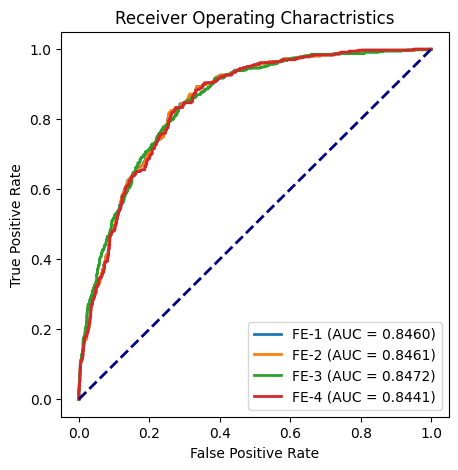

In [56]:
logreg = LogisticRegression()

datasets = {"FE-1":[X_train_OH1, X_test_OH1, y_train1, y_test1],
             "FE-2":[X_train_OH2, X_test_OH2, y_train2, y_test2],
             "FE-3":[X_train_OH3, X_test_OH3, y_train3, y_test3],
             "FE-4":[X_train_OH4, X_test_OH4, y_train4, y_test4]}

roc_auc_comparison(logreg, datasets)

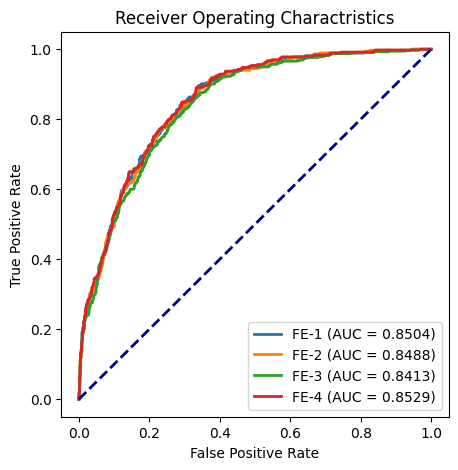

In [57]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier()

roc_auc_comparison(adaboost, datasets)

In [58]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

linear_svc = SVC(kernel='linear', probability=False)
lda = LinearDiscriminantAnalysis()

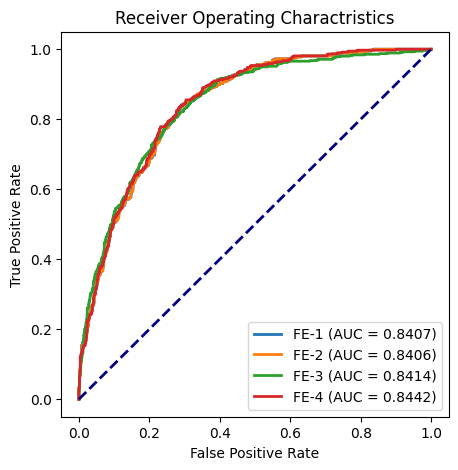

In [59]:
roc_auc_comparison(linear_svc, datasets)

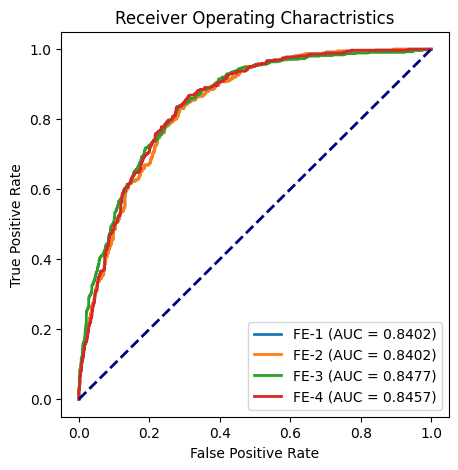

In [60]:
roc_auc_comparison(lda, datasets)

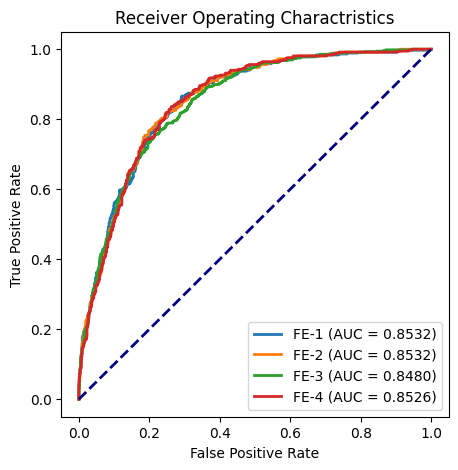

In [61]:
from sklearn.ensemble import RandomForestClassifier

rfclassifier = RandomForestClassifier(random_state = 1, max_depth=6, min_samples_leaf=7)
roc_auc_comparison(rfclassifier, datasets)

### Dataset Balancing

We can also try balancing the dataset using `SMOTE`, `SMOTEENN` and `ADASYN`

In [62]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

smote=SMOTE(sampling_strategy='auto', random_state=1)
adasyn = ADASYN(sampling_strategy='auto', random_state=1, n_neighbors=5)
smoteenn = SMOTEENN(sampling_strategy='auto', random_state=1)

#### SMOTE

In [63]:
# Feature Engineering 1
X_train_smote1, y_train_smote1 = smote.fit_resample(X_train_OH1, y_train1)

# Feature Engineering 2
X_train_smote2, y_train_smote2 = smote.fit_resample(X_train_OH2, y_train2)

# Feature Engineering 3
X_train_smote3, y_train_smote3 = smote.fit_resample(X_train_OH3, y_train3)

# Feature Engineering 4
X_train_smote4, y_train_smote4 = smote.fit_resample(X_train_OH4, y_train4)


In [66]:
datasets2 = {"SM-1":[X_train_smote1, X_test_OH1, y_train_smote1, y_test1],
             "SM-2":[X_train_smote2, X_test_OH2, y_train_smote2, y_test2],
             "SM-3":[X_train_smote3, X_test_OH3, y_train_smote3, y_test3],
             "SM-4":[X_train_smote4, X_test_OH4, y_train_smote4, y_test4]}

In [74]:
for key, data in datasets2.items():
    lz_clf = LazyClassifier()
    X_train, X_test, y_train, y_test = data
    models, predictions = lz_clf.fit(X_train, X_test, y_train, y_test)
    display(models.sort_values(by='F1 Score', ascending=False)[:5])

100%|██████████| 29/29 [00:13<00:00,  2.14it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.78,0.72,0.72,0.78,0.44
RandomForestClassifier,0.78,0.72,0.72,0.78,0.65
SVC,0.77,0.75,0.75,0.78,1.62
LGBMClassifier,0.78,0.72,0.72,0.78,0.47
AdaBoostClassifier,0.77,0.78,0.78,0.78,0.38


100%|██████████| 29/29 [00:10<00:00,  2.65it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.78,0.73,0.73,0.79,0.63
LGBMClassifier,0.78,0.72,0.72,0.78,0.45
XGBClassifier,0.78,0.72,0.72,0.78,0.38
SVC,0.77,0.75,0.75,0.78,1.19
AdaBoostClassifier,0.77,0.77,0.77,0.78,0.26


100%|██████████| 29/29 [00:10<00:00,  2.76it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.78,0.75,0.75,0.79,1.46
LGBMClassifier,0.78,0.71,0.71,0.78,0.45
XGBClassifier,0.78,0.71,0.71,0.78,0.35
SVC,0.77,0.74,0.74,0.78,1.20
RandomForestClassifier,0.78,0.70,0.70,0.78,0.56


100%|██████████| 29/29 [00:10<00:00,  2.74it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.73,0.73,0.79,0.44
XGBClassifier,0.78,0.71,0.71,0.78,0.34
SVC,0.77,0.75,0.75,0.78,1.15
RandomForestClassifier,0.78,0.71,0.71,0.78,0.57
BaggingClassifier,0.78,0.71,0.71,0.78,0.17


In [75]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import NuSVC

In [76]:
logreg = LogisticRegression()
adaboost = AdaBoostClassifier()
linear_svc = SVC(kernel='linear', probability=False)
lda = LinearDiscriminantAnalysis()
rfclassifier = RandomForestClassifier(n_estimators=100, random_state = 1, max_depth=6, min_samples_leaf=7)
lgbm = LGBMClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
nu_svc = NuSVC(probability=True)

models = [logreg, adaboost, linear_svc, lda, rfclassifier, lgbm, xgb, nu_svc]

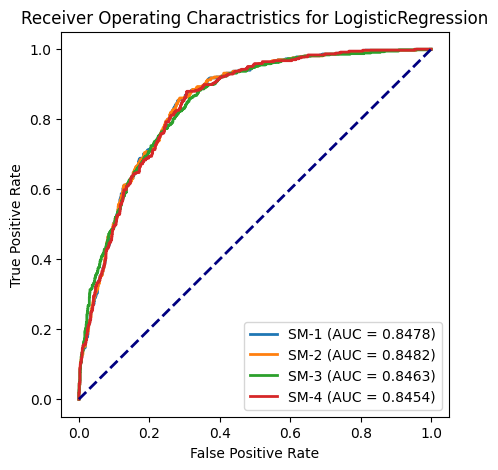

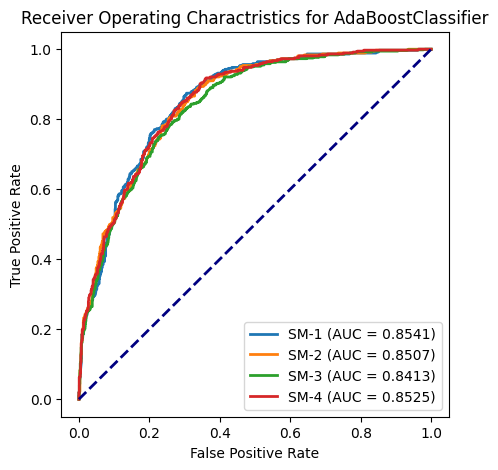

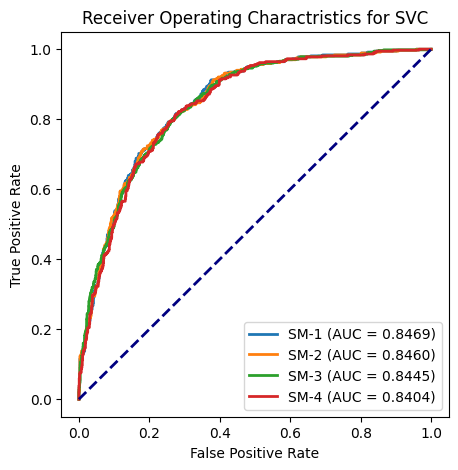

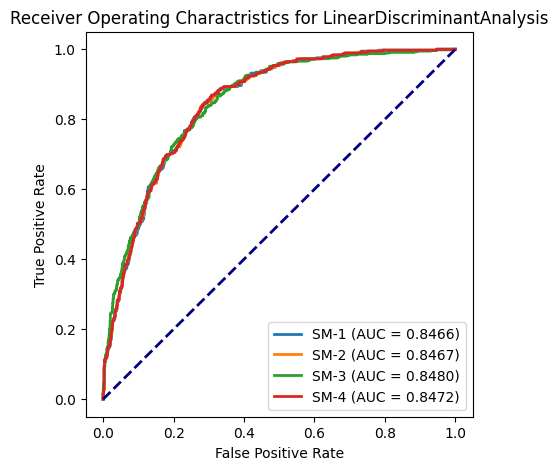

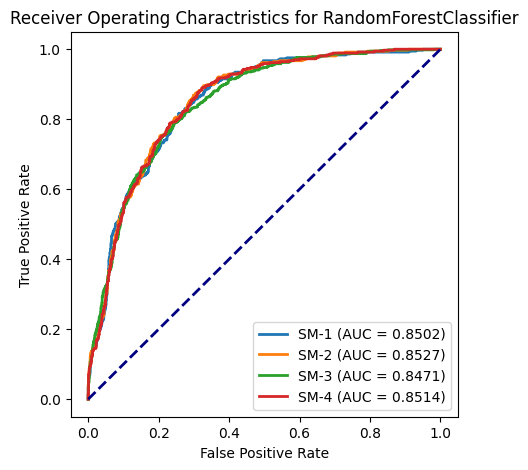

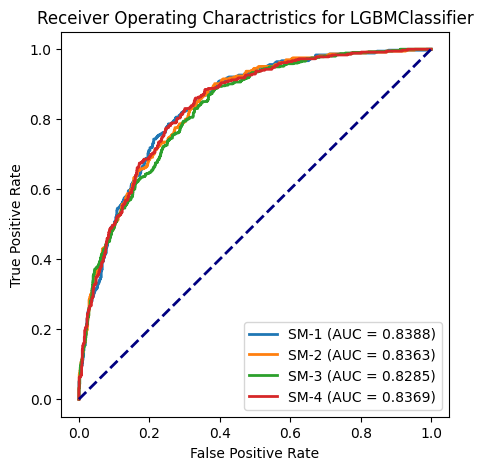

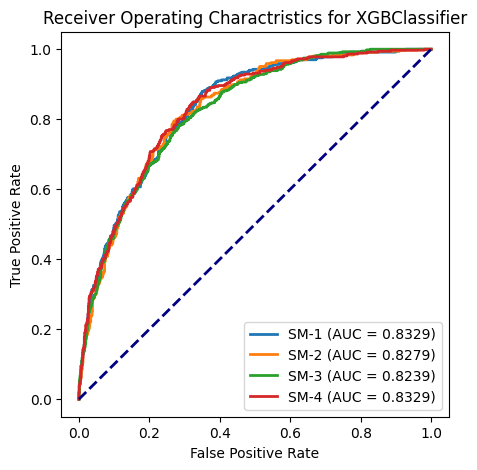

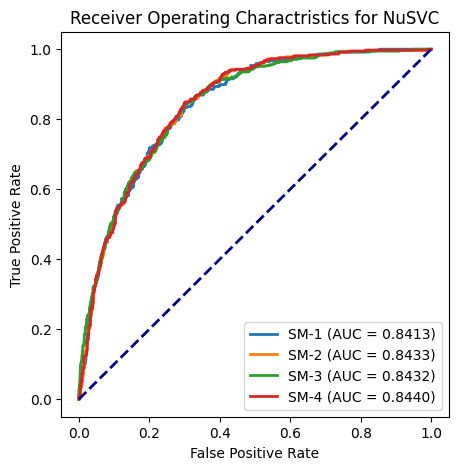

In [81]:
for model in models:
    roc_auc_comparison(model, datasets2)